In [1]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson
from seirsplus.models import *
from seirsplus.networks import *
from seirsplus.sim_loops import *
from seirsplus.utilities import *
from network_utils import *
from stats_utils import *
from intervention_utils import *
from camp_params import *
import pickle as pkl
from littleballoffur import RandomNodeSampler, DegreeBasedSampler, PageRankBasedSampler

In [2]:
# TODO: Update this in model_server
def link_nodes_by_activity(base_graph, nodes_per_struct, percentage_per_struct, proximity_radius, edge_weight,
                           activity_name):
    """ Connect a given percentage of nodes per structure that engage in the same activity
        with other nodes from different structures that engage in the same activity, at a given proximity radius
        Examples of activities:
        - Food queue
        - Religious events
    """
    graph = base_graph.copy()

    activity_bois = set()

    # Choose a percentage of people randomly from each structure
    for node_list in nodes_per_struct:
        if len(node_list) == 1:
            activity_bois.add(node_list[0])
        else:
            for i in range(int(len(node_list) * percentage_per_struct)):
                activity_bois.add(np.random.choice(node_list))

    activity_bois = list(activity_bois)
    np.random.shuffle(activity_bois)

    # Draw an edge between everyone in the list within a given proximity
    for i in range(len(activity_bois) - proximity_radius):
        for j in range(i + 1, i + proximity_radius + 1):
            if not graph.has_edge(activity_bois[i], activity_bois[j]):
                graph.add_edge(
                    activity_bois[i],
                    activity_bois[j],
                    weight=edge_weight,
                    label=activity_name)
    return graph

In [3]:
n_pop = 18700

# Grid info for isoboxes
dims_isoboxes = (29, 28)  # 812

# Grid info for tents
dims_block1 = (20, 67)  # 1340
dims_block2 = (53, 15)  # 795
dims_block3 = (19, 28)  # 532

# Isoboxes
pop_isoboxes = 8100
pop_per_isobox = 10
n_isoboxes = dims_isoboxes[0]*dims_isoboxes[1]

# Tents
n_tents = 2650
pop_tents = 10600
pop_per_tent = 4

# Others 
n_bathrooms = 144
n_ethnic_groups = 8

# We define neighboring structures within a range of 2 in the structure grid
proximity = 2

# Define the maximum population per structures (tents and isoboxes) drawn from a poisson distribution
max_pop_per_struct = list(poisson.rvs(mu=pop_per_isobox, size=n_isoboxes))
max_pop_per_struct = max_pop_per_struct + list(poisson.rvs(mu=pop_per_tent, size=dims_block1[0]*dims_block1[1]))
max_pop_per_struct = max_pop_per_struct + list(poisson.rvs(mu=pop_per_tent, size=dims_block2[0]*dims_block2[1]))
max_pop_per_struct = max_pop_per_struct + list(poisson.rvs(mu=pop_per_tent, size=dims_block3[0]*dims_block3[1]))

n_structs = len(max_pop_per_struct)

# Sample the population age, and parameter rates
sample_pop = sample_population(n_pop, "data/augmented_population.csv")

In [4]:
# graph, nodes_per_struct = load_graph("experiments/networks/Moria_wNeighbors_4")

household_weight = 0.98
graph, nodes_per_struct = create_graph(n_structs, 0, n_pop, max_pop_per_struct, 
                                       edge_weight=household_weight, label="household",
                                       age_list=list(sample_pop["age"]),
                                       sex_list = list(sample_pop["sex"]),
                                       n_ethnicities=n_ethnic_groups)

100%|██████████| 18700/18700 [00:16<00:00, 1106.12it/s]


In [5]:
food_weight = 0.407
# graph_1fq = connect_food_queue(graph, nodes_per_struct, food_weight, "food")
graph_1fq = link_nodes_by_activity(graph, nodes_per_struct, percentage_per_struct=0.5, proximity_radius=5, edge_weight=food_weight, activity_name="food")

In [6]:
neighbor_weight = 0.017

graph_1fq = link_nodes_by_property(graph_1fq, 0, n_isoboxes, nodes_per_struct,
                              grid_isoboxes, 2, "ethnicity", neighbor_weight, 'friendship')
graph_1fq = link_nodes_by_property(graph_1fq, dims_isoboxes[0]*dims_isoboxes[1], dims_block1[0]*dims_block1[1], nodes_per_struct,
                              grid_block1, 2, "ethnicity", neighbor_weight, 'friendship')
graph_1fq = link_nodes_by_property(graph_1fq, dims_block1[0]*dims_block1[1], dims_block2[0]*dims_block2[1], nodes_per_struct,
                              grid_block2, 2, "ethnicity", neighbor_weight, 'friendship')
graph_1fq = link_nodes_by_property(graph_1fq, dims_block2[0]*dims_block2[1], dims_block3[0]*dims_block3[1], nodes_per_struct,
                              grid_block3, 2, "ethnicity", neighbor_weight, 'friendship')

Total pop:
Degree: mean = 22.59, std = 15.62, 95% CI = (2.00, 49.00)
        coeff var = 0.69
Assortativity:    0.02
Clustering coeff: 0.41



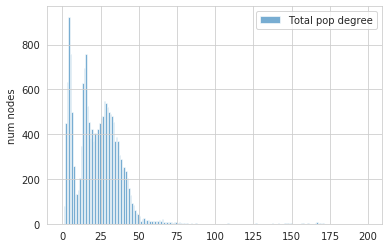

In [7]:
network_info(graph_1fq, "Total pop", plot=True)

In [16]:
from littleballoffur.exploration_sampling import LoopErasedRandomWalkSampler, BreadthFirstSearchSampler, DepthFirstSearchSampler

from littleballoffur.exploration_sampling import CommunityStructureExpansionSampler, CirculatedNeighborsRandomWalkSampler, SnowBallSampler
from littleballoffur.exploration_sampling import RandomWalkSampler, MetropolisHastingsRandomWalkSampler, CommonNeighborAwareRandomWalkSampler
from littleballoffur.exploration_sampling import NonBackTrackingRandomWalkSampler, RandomWalkWithRestartSampler, ForestFireSampler, SpikyBallSampler

from littleballoffur.exploration_sampling import ShortestPathSampler, RandomWalkWithJumpSampler, FrontierSampler, RandomNodeNeighborSampler

In [69]:
samplers = [RandomNodeSampler,
            DegreeBasedSampler,
            PageRankBasedSampler,
            LoopErasedRandomWalkSampler,
            BreadthFirstSearchSampler,
            DepthFirstSearchSampler,
            CirculatedNeighborsRandomWalkSampler,
            SnowBallSampler,
            RandomWalkSampler,
            MetropolisHastingsRandomWalkSampler,
            CommonNeighborAwareRandomWalkSampler,
            NonBackTrackingRandomWalkSampler,
            RandomWalkWithRestartSampler,
            ForestFireSampler,
            SpikyBallSampler,
            ShortestPathSampler,
            RandomWalkWithJumpSampler,
            FrontierSampler,
            RandomNodeNeighborSampler]

num_of_nodes = [int(n_pop / 4) for _ in range(len(samplers) - 1)]
num_of_nodes.append(250)

mean_meandegree = []
mean_meanclustercoeff = []
mean_maxdegree = []

In [70]:
from tqdm import tqdm

for n in tqdm(range(len(samplers))):
    mean_degree = []
    mean_clustercoeff = []
    for i in range(10):
        subgraph = samplers[n](number_of_nodes=num_of_nodes[n], seed=np.random.randint(69)).sample(graph_1fq)
        degrees = [d[1] for d in subgraph.degree()]
        
        mean_clustercoeff.append(nx.average_clustering(subgraph))
        mean_degree.append(np.mean(degrees))
        max_degree = np.max(degrees)
    mean_meandegree.append(np.mean(mean_degree))
    mean_meanclustercoeff.append(np.mean(mean_clustercoeff))
    mean_maxdegree.append(np.mean(max_degree))


100%|██████████| 19/19 [07:47<00:00, 24.58s/it]


In [72]:
maxidx_deg = np.argmax(mean_meandegree)
maxidx_cc = np.argmax(mean_meanclustercoeff)
maxidx_maxdeg = np.argmax(mean_maxdegree)

print(f'{samplers[maxidx_deg]}:\n'
      f'    Degree: {mean_meandegree[maxidx_deg]}'
      f'    CC: {mean_meanclustercoeff[maxidx_deg]}'
      f'    MaxDeg: {mean_maxdegree[maxidx_deg]}')

print(f'{samplers[maxidx_cc]}:\n'
      f'    Degree: {mean_meandegree[maxidx_cc]}'
      f'    CC: {mean_meanclustercoeff[maxidx_cc]}'
      f'    MaxDeg: {mean_maxdegree[maxidx_cc]}')

print(f'{samplers[maxidx_maxdeg]}:\n'
      f'    Degree: {mean_meandegree[maxidx_maxdeg]}'
      f'    CC: {mean_meanclustercoeff[maxidx_maxdeg]}'
      f'    MaxDeg: {mean_maxdegree[maxidx_maxdeg]}')

<class 'littleballoffur.exploration_sampling.snowballsampler.SnowBallSampler'>:
    Degree: 16.866951871657754    CC: 0.3978619169894769    MaxDeg: 182.0
<class 'littleballoffur.exploration_sampling.randomnodeneighborsampler.RandomNodeNeighborSampler'>:
    Degree: 15.657090990407752    CC: 0.4341312880974666    MaxDeg: 64.0
<class 'littleballoffur.exploration_sampling.snowballsampler.SnowBallSampler'>:
    Degree: 16.866951871657754    CC: 0.3978619169894769    MaxDeg: 182.0


4675
148
Degree: mean = 16.75, std = 10.56, 95% CI = (4.00, 39.00)
        coeff var = 0.63
Assortativity:    -0.04
Clustering coeff: 0.42



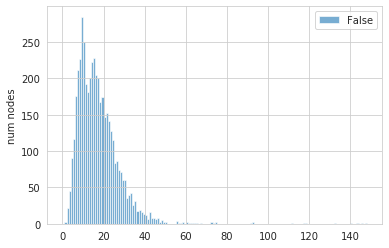

In [74]:
subgraph = SnowBallSampler(number_of_nodes=int(n_pop / 4), seed=np.random.randint(100)).sample(graph_1fq)
print(len(subgraph))
degrees = [d[1] for d in subgraph.degree()]
print(np.max(degrees))
network_info(subgraph, plot=True)

In [38]:
mean_meandegree[20:]

[10.69625668449198,
 6.618224598930482,
 1.999572192513369,
 1.999572192513369,
 1.999572192513369,
 12.841240641711229,
 16.93621390374331,
 12.940663101604278,
 10.753026737967916,
 13.357048128342246,
 12.732491978609627,
 13.775486631016046,
 15.11585026737968,
 7.201368983957219,
 9.949732620320855,
 11.161326203208557,
 2.5083636363636366,
 23.449915801900588]

In [39]:
mean_meanclustercoeff[20:]

[0.2613620176217964,
 0.28594274558902266,
 0.0,
 0.0,
 0.0,
 0.30512494210546875,
 0.38794642074464697,
 0.3103829213661551,
 0.35640884141072193,
 0.2544335754876084,
 0.31097429540345134,
 0.3031337900920909,
 0.2899338441665268,
 0.3748952732379867,
 0.25903216426927755,
 0.32152843459935376,
 0.03686278269374245,
 0.39077650300767264]

4859
174
Degree: mean = 15.55, std = 9.72, 95% CI = (4.00, 38.00)
        coeff var = 0.62
Assortativity:    -0.05
Clustering coeff: 0.44



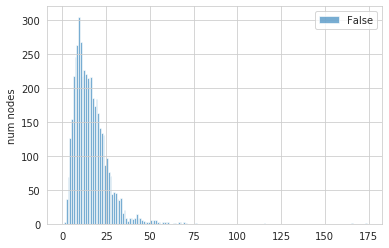

In [58]:
subgraph = RandomNodeNeighborSampler(number_of_nodes=250, seed=np.random.randint(100)).sample(graph_1fq)
print(len(subgraph))
degrees = [d[1] for d in subgraph.degree()]
print(np.max(degrees))
network_info(subgraph, plot=True)

4675
80
Degree: mean = 13.13, std = 8.07, 95% CI = (3.00, 29.15)
        coeff var = 0.61
Assortativity:    0.06
Clustering coeff: 0.30



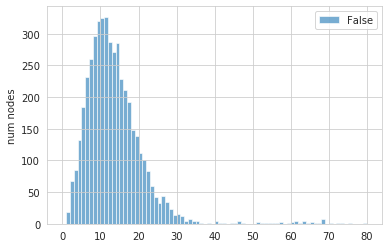

In [59]:
subgraph = CirculatedNeighborsRandomWalkSampler(number_of_nodes=int(n_pop / 4), seed=np.random.randint(100)).sample(graph_1fq)
print(len(subgraph))
degrees = [d[1] for d in subgraph.degree()]
print(np.max(degrees))
network_info(subgraph, plot=True)

In [60]:
degrees = [d[1] for d in graph_1fq.degree()]
print(np.max(degrees))

199


In [61]:
sampler = CirculatedNeighborsRandomWalkSampler

test = sampler(number_of_nodes=int(n_pop / 4), seed=np.random.randint(100)).sample(graph_1fq)

In [63]:
network_info(test)

Degree: mean = 12.82, std = 7.05, 95% CI = (3.00, 27.00)
        coeff var = 0.55
Assortativity:    0.06
Clustering coeff: 0.31

